In [5]:
#The code for experiments with SIR epidemic control by delayed isolation
#on temporal Barabasi-Albert graph.
#Vikenty Mikheev, Kansas State University
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from collections import defaultdict
from itertools import combinations
from copy import deepcopy
import pylab as plb
import matplotlib._color_data as mcd
import seaborn as sns

plb.rcParams['font.size'] = 16

LenSick=30 #The length of the sickness
#Random number generator.
#It appeared easier to write from scratch than saving the states
#in multiple loops.
def MyRand(r):
    a=421
    c=1663
    m=7875
    next_r = (a*r+c)%m
    stand_r = 1.0*next_r/m
    return stand_r, next_r

#Graph modifications: isolation of public
 # If a friend is popular, we won't see him for awhile
def GetTempNeig(G,node,tt):
    #returns all TEMPORAL neigbors for the node x available for ALL time momements in the LIST tt
    #
    Res=[]
    for neig in G.neighbors(node):
        #check if all elements of tt are contained in the edge
        contained =  all(elem in G[node][neig]['t']  for elem in tt)
        if contained:
                Res.append(neig)
    
    return Res
    
    
def NoGathering(G, maxCrowdSize , StartTime, EndTime):
    H=deepcopy(G)
    QuarantineTimes=[item for item in range(StartTime,EndTime)]         
    for x in H.nodes(): #Probably it would be better to presort this by degrees of nodes.
        for neig in GetTempNeig(H,x, QuarantineTimes): #loop over temp neighbors
            if len(GetTempNeig(H,neig, QuarantineTimes)) >= maxCrowdSize: #if temp degree is greater than...
                H[x][neig]['t'][StartTime-1:EndTime-1]=[-1 for _ in range(0,EndTime-StartTime)]
    return H

#Old version of Isolation when popular nodes were completely disconnected during isolation period
def NoGatheringDeletion(G, maxCrowdSize , StartTime, EndTime): # The error must be here. Starts fr
    H=deepcopy(G) 
    for x in H.nodes():
        for neig in H.neighbors(x):
            if H.degree(neig)>= maxCrowdSize:
                H[x][neig]['t'][StartTime-1:EndTime-1]=[-1 for _ in range(0,EndTime-StartTime)]
    return H

def GetNeigbForInf(G,listInf,healed,tt):
    #returns all TEMPORAL neigbors for the give list of nodes excluding the original nodes and healed
    Res=[]
    for x in listInf:
        for neig in G.neighbors(x):
                if neig not in healed:
                    if neig not in listInf:
                        if tt in G[x][neig]['t']:
                            Res.append(neig)
    for x in listInf:
        if x in Res:
            Res.remove(x)
    return Res

#Here we make the schedules for citezens.
#For now, every edge is available every day    
def RandTempGraph(n,m,Tmax):  
#Input: n - number of nodes
#       m - the number of new edges coming with each new node 
#in Barabasi-Albert graph

    G=nx.barabasi_albert_graph(n, m, seed=100)
    nx.set_node_attributes(G, (0,0), 'status') 
    #0 - suseptable, 1 - infected, 2 - healed; second number is how long being infected

    for e,(u,v) in enumerate(G.edges()):
        G[u][v]['enum'] = e  # enumerate edges
        #random edge times
        #edgetimes = [random.randint(0, Tmax) for i in range(0,nT) ]
        #edgetimes.sort()
        #regualar edge times
        edgetimes = [item for item in range(1,Tmax+1)]
        G[u][v]['t']= edgetimes

    

    return G

#The epidemic process simulation: Everyday every contegeous node 
#infects with probability p=0.02 all its temporal neighbors.
#Once infected after 30 days become "recovered", i.e. not contegeous
#and can't be infected no more.
def epidemic(G,infected,Tmax,r):

#Input: G - graph, infected - list of initialy infected,
# Tmax - how many days do we want to simulate the process of epidemic
# r - random seed
#Output: G - graph
# infected - list of nodes who are still infected at the end
# healed - list of who is healed at the end
# infected_st - list: numbers of how many were infected (with healed) infected by each day
# healed_st - list: numbers of how many healed by each day
# Stat - list: the difference of infected_st and healed_st

    Stat=[len(infected)]
    for node in infected:
        G.nodes[node]['status']=(1,0) #zero days of infection
       
    infected_st = []
    S_inf=len(infected)
    healed_st=[]
    S_hea=0
    healed=[]
    
    for tt in range(1,Tmax): #time loop
        infected_today=0
        healed_today  =0
        infected_copy=infected.copy()
        
        for x in infected:           
            status = G.nodes[x]['status']
            if status[1]>LenSick-1:               
                G.nodes[x]['status']=(2,0) #healed
                infected_copy.remove(x)
                healed.append(x)
                healed_today += 1
            else:    
                G.nodes[x]['status']=(status[0],status[1]+ 1)
                
        infected=infected_copy
        #statistics of infected
                
        NeigList = GetNeigbForInf(G,infected,healed,tt) #list of exposed without already infected   
        for neigInf in NeigList:
            
            stand_r,new_r = MyRand(r)
            r=new_r
            if neigInf not in infected:
                if stand_r < p:
                    G.nodes[neigInf]['status']= (1,0)  
                    infected.append(neigInf)
                    infected_today += 1
        S_inf+= infected_today
        S_hea+= healed_today
        infected_st.append(S_inf)
        healed_st.append(S_hea)
        Stat.append(len(infected))
        
        
    return G,infected, healed, infected_st,healed_st,Stat



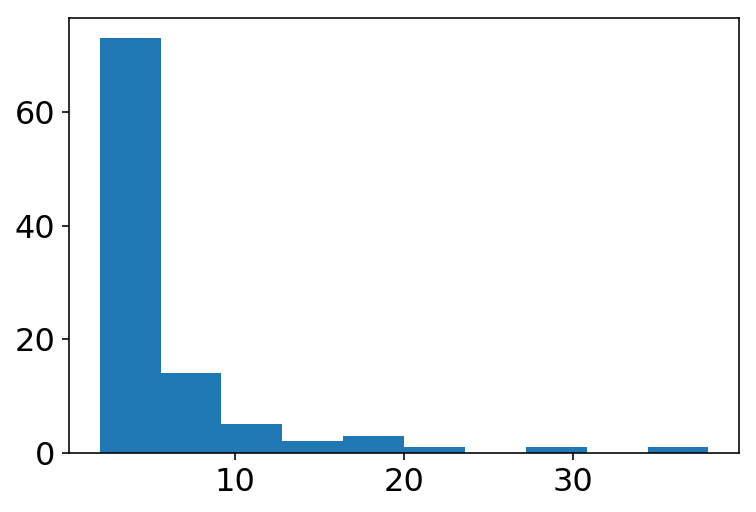

ave degs: 5.82


/ext/anaconda5/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


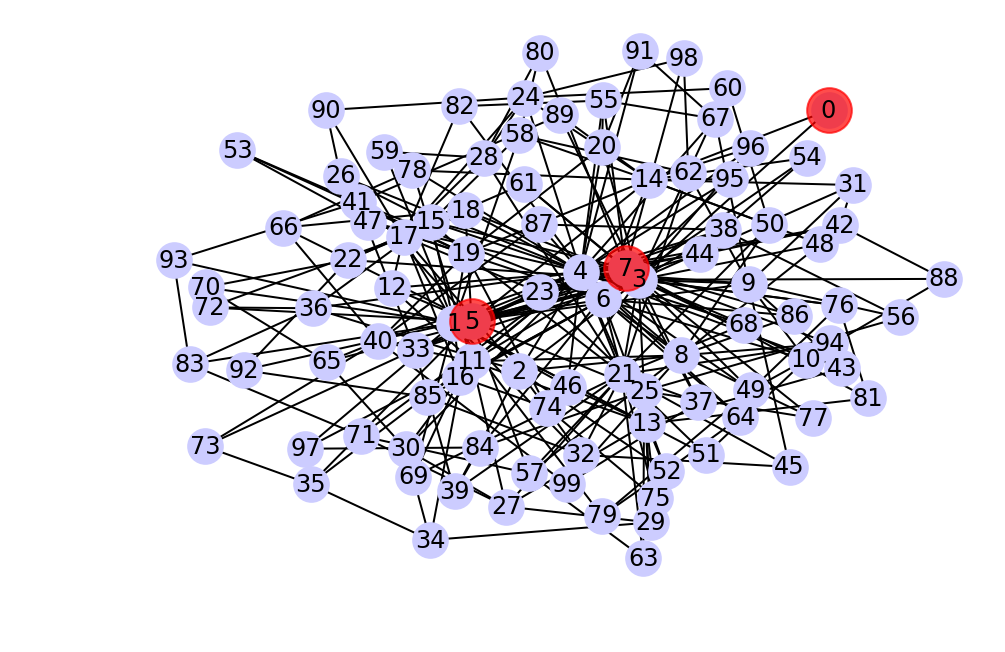

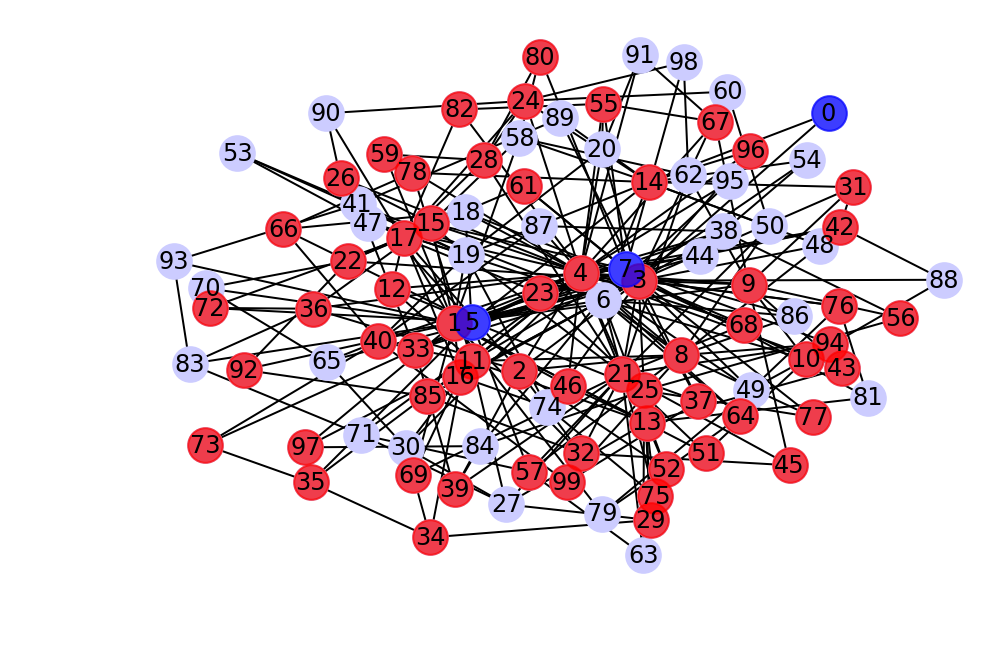

931 32


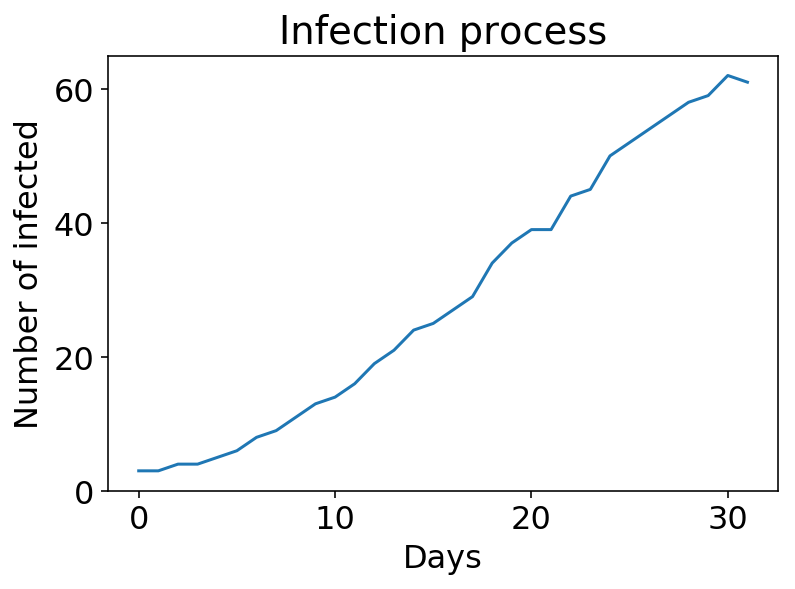

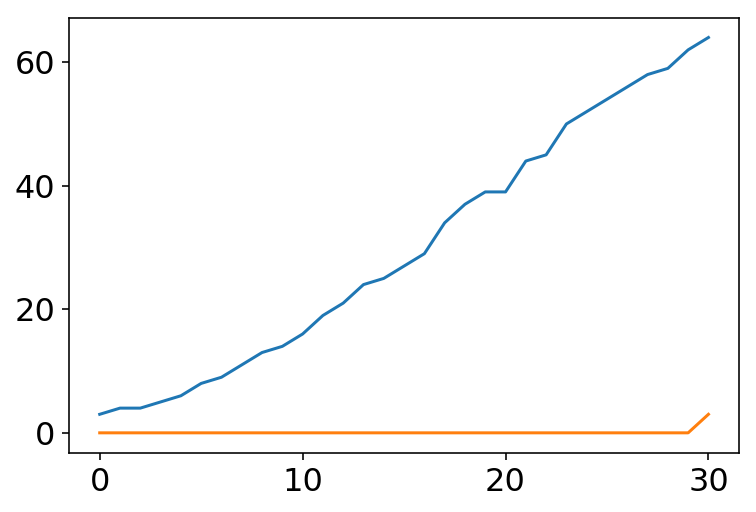

In [8]:
n=5000 #number of nodes
p=0.02 # probability of transfering the desease
Tmax=32
m=3

infsetup=[0,5,7]

#Generate the social graph
G = RandTempGraph(n,m,Tmax)

Degs = G.degree
D=[x[1] for x in Degs]
plt.hist(D)
plt.show()
print("ave degs:", 1.0*sum(D)/len(D))

infected=infsetup.copy()  

plt.figure(1)
pos = nx.spring_layout(G)
nx.draw(G,pos,with_labels=True,node_color='#ccccff')
nx.draw_networkx_nodes(G,pos,
                        nodelist=infected,
                        node_color='r',
                        node_size=500,
                    alpha=0.7)
plt.show()



#Infect the graph

#Time iterations. Infection & healing process. No measures
r=1
GG = deepcopy(G)
G_after, infected,healed, infected_st, healed_st, Stat = epidemic(GG,infected,Tmax,r)

nx.draw(G_after,pos,with_labels=True,node_color='#ccccff')

nx.draw_networkx_nodes(G_after,pos,
                       nodelist=infected,
                       node_color='r',
                       node_size=300,
                   alpha=0.7)
nx.draw_networkx_nodes(G_after,pos,
                       nodelist=healed,
                       node_color='b',
                       node_size=300,
                   alpha=0.7)

plt.show()
print(sum(Stat),len(Stat))


infected=infsetup.copy()
r=1
plt.plot(Stat)

plt.xlabel('Days')
plt.ylabel('Number of infected')
plt.title('Infection process')

plt.show()
plt.plot(infected_st)
plt.plot(healed_st)
plt.show()



Text(0, 0.5, 'Infected')

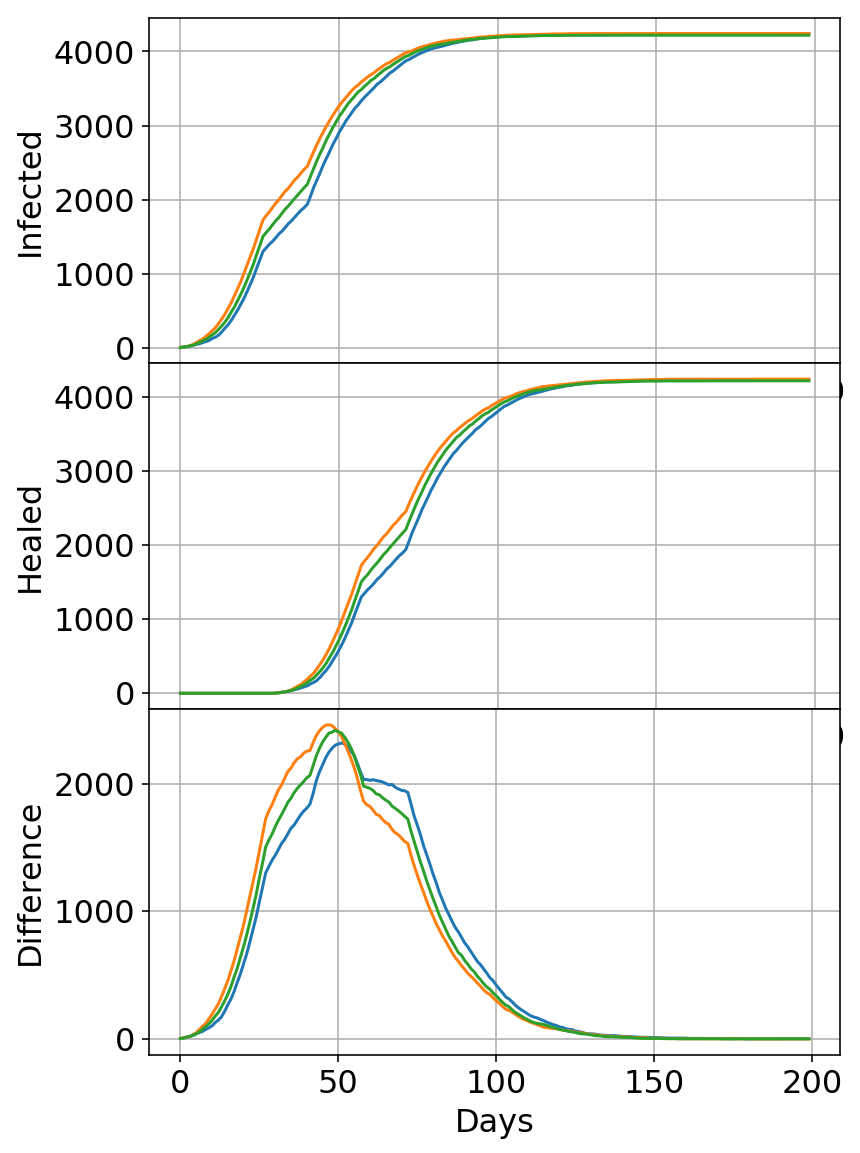

In [10]:
#Here we show variablitly of 2w isolation on 28-th day and stats of infected and healed

n=5000 #number of nodes
p=0.02 # probability of transfering the desease
#nT=60 # number of time moments on an edge
Tmax=200
m=3

#Generate the social graph
G = RandTempGraph(n,m,Tmax)
infsetup=[0,5,7] #set up initial infected nodes

fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.6, 0.8, 0.6]) 
                  
ax2 = fig.add_axes([0.1, 0.0, 0.8, 0.6])             
ax3 = fig.add_axes([0.1, -0.6, 0.8, 0.6])


w=14

for r in [1,5,7]:
   
    H=deepcopy(G)
    G1=NoGathering(H, 5 , 28, 28+w)
    infected=infsetup.copy()
    G_inf2, infected2, healed2, infected_st, healed_st, Stat2 = epidemic(G1,infected,Tmax,r)
    
        
    ax1.plot(infected_st)
    ax2.plot(healed_st)
    ax3.plot(Stat2)
ax1.grid()
ax2.grid()
ax3.grid()
ax3.set_xlabel('Days')
ax3.set_ylabel('Difference')
ax2.set_ylabel('Healed')
ax1.set_ylabel('Infected')

In [6]:
#A wrap procedure for the experiments with delayed isolation
def isolationExper(H, infsetup,w,t,Tmax,r=[1,4,7],groupsize=5):
#    
    
    fig = plt.figure()
    ax1 = fig.add_axes([0.1, 0.6, 0.8, 0.6]) #[left, bottom, width, height] 
    ax2 = fig.add_axes([0.1, 0.0, 0.8, 0.6])#,                   ylim=(-1.2, 1.2))
    ax3 = fig.add_axes([0.1, -0.6, 0.8, 0.6])#, label='Days')
    
    palette = plt.get_cmap('Set1')
    rcount=0
    for rr in r:
        
        Stats=[]
        FinalSumOfInf=[]
        count=rcount
        
        for ttt in t:            
            if ttt==-1: #If NO isolation 
                G=deepcopy(H)
                infected=infsetup.copy()
                #Time iterations. Infection & healing process. No measures
                G_after, infected2, healed2,infected_st, healed_st, Stat1 = epidemic(G,infected,Tmax,rr)
                ax1.plot(infected_st,"--",color=palette(count))
                ax2.plot(healed_st,"--",color=palette(count))
                ax3.plot(Stat1,"--",label='No isolation',color=palette(count))

                Stats.append(Stat1)
                FinalSumOfInf.append(infected_st[-1])
                count+=1
            else:
                          
                
                infected=infsetup.copy()
                G=deepcopy(H)
                G1=NoGathering(G, groupsize , ttt, ttt+w)

                G_inf2, infected,healed,infected_st, healed_st, Stat2 = epidemic(G1,infected,Tmax,rr)
                ax1.plot(infected_st,color=palette(count))
                ax2.plot(healed_st,color=palette(count))
                ax3.plot(Stat2,label='from '+str(ttt)+'-th day',color=palette(count))
                Stats.append(Stat2)
                FinalSumOfInf.append(infected_st[-1])
                count+=1
                if count==5: #Some people can't see yellow
                    count+=1
        #end of for tt loop
        print("Final Sums of all ever infected for random seed ",rr," is ", FinalSumOfInf)
        print("max values of infected-healed: ",np.max(Stats,axis=1))
        rcount+=len(t)
    #end of for rr loop
    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax3.set_xlabel('Days')
    ax3.set_ylabel('Difference')
    ax2.set_ylabel('Healed')
    ax1.set_ylabel('Infected')
    plt.legend( bbox_to_anchor=(0.475, 0.4))
    plt.show()

    return 1#FinalSumOfInf

ave degs: 5.9964


Final Sums of all ever infected for random seed  1  is  [4450, 4405, 4342, 4237, 4230, 4270]
max values of infected-healed:  [3208 3013 2700 2319 2551 2985]


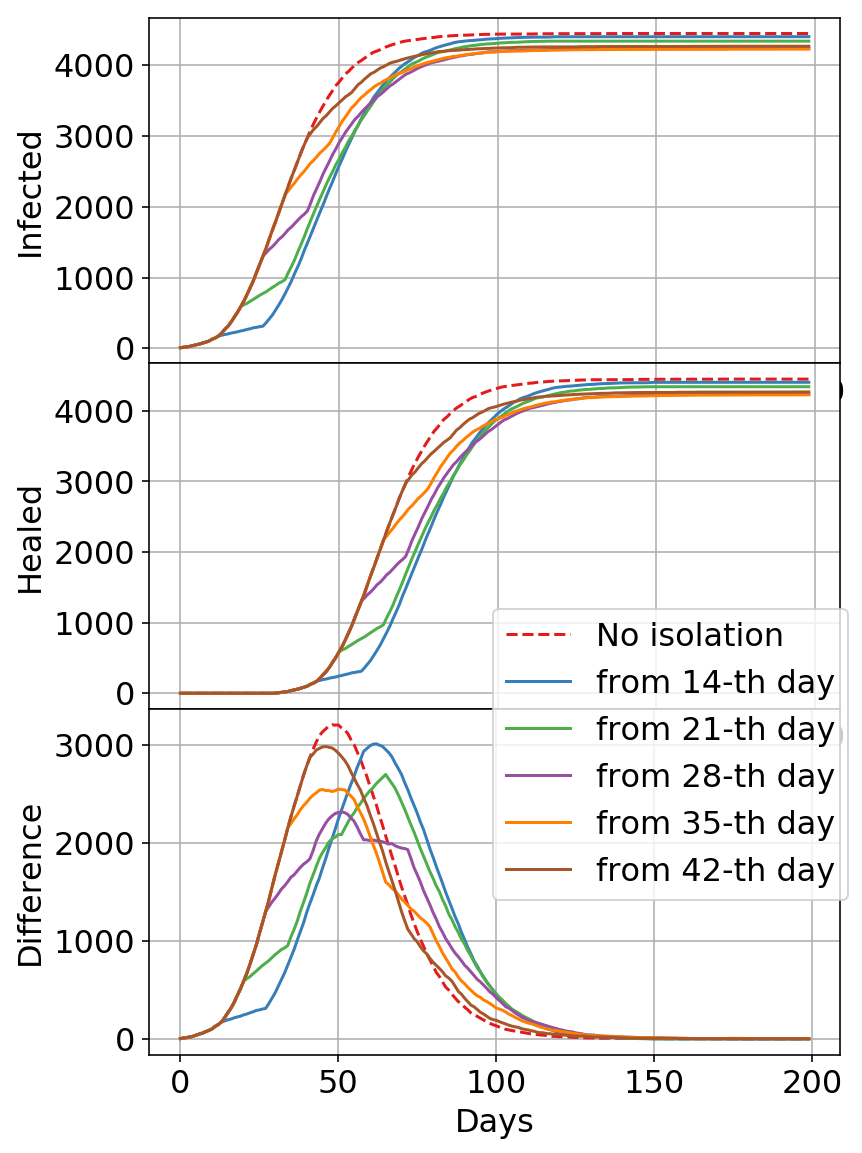

Experiment 1:  1


In [11]:
n=5000 #number of nodes
p=0.02 # probability of transfering the desease
Tmax=200#180
m=3

#Generate the social graph
G = RandTempGraph(n,m,Tmax)
Degs = G.degree
D=[x[1] for x in Degs]
#plt.hist(D)
#plt.show()
print("ave degs:", 1.0*sum(D)/len(D))

infsetup=[0,5,7] #set up initial infected nodes

r=[1]
w=14 #period of isolation
#  "-1" means "no isolation". 
t= [-1,14,21,28,35,42] #times to start isolation #must be smaller than Tmax!!
print("Experiment 1: ",isolationExper(G, infsetup,w,t,Tmax,r))

Final Sums of all ever infected for random seed  2  is  [4451, 4217, 4025, 3833, 3922, 4159]
max values of infected-healed:  [3208 2162 1441 2202 2764 3100]


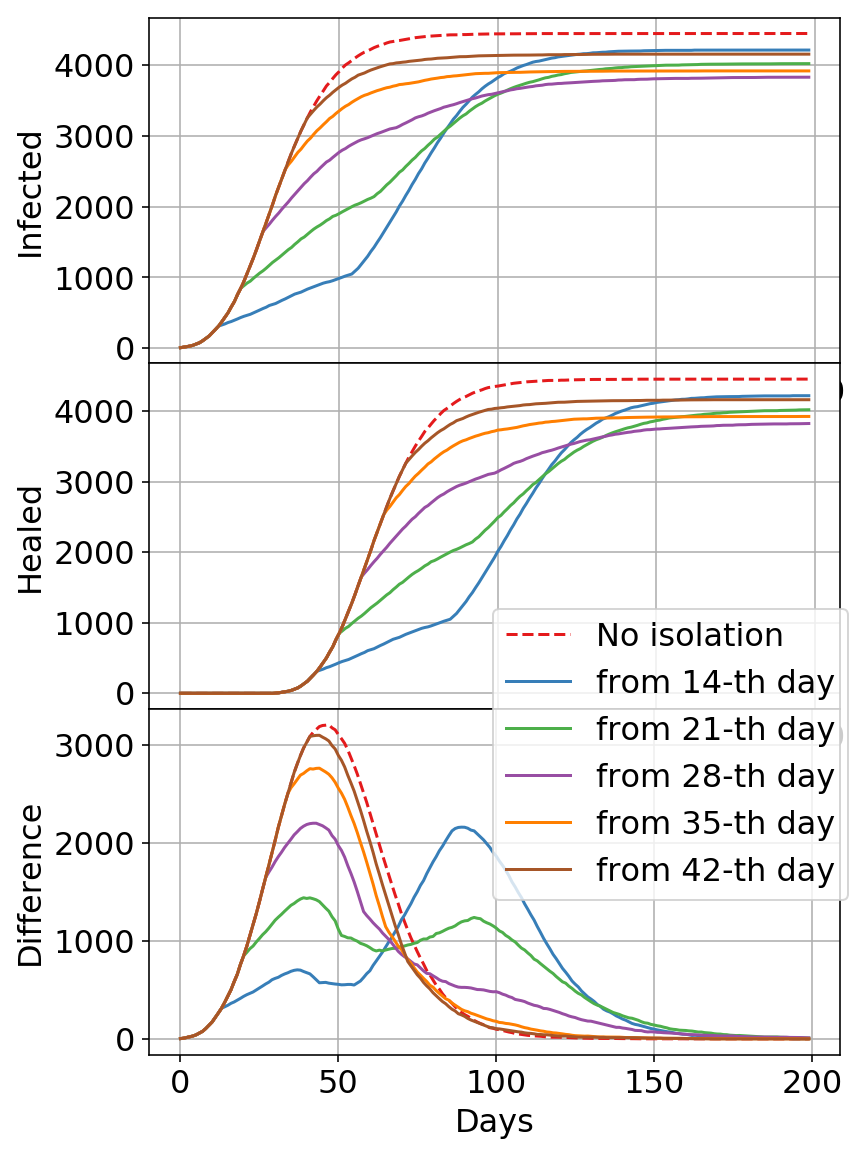

Experiment 2:  1


In [8]:
n=5000 #number of nodes
p=0.02 # probability of transfering the desease
Tmax=200
m=3

#Generate the social graph
G = RandTempGraph(n,m,Tmax)
infsetup=[0,5,7] #,5,7,10] #set up initial infected nodes

r=[1]
w=28 #period of isolation
t= t= [-1,14,21,28,35,42] #times to start isolation #must be smaller than Tmax!!
print("Experiment 2: ",isolationExper(G, infsetup,w,t,Tmax,r))


Final Sums of all ever infected for random seed  1  is  [4450, 4288, 4070, 3900, 3888, 4105]
max values of infected-healed:  [3208 2447 1497 1897 2547 2985]


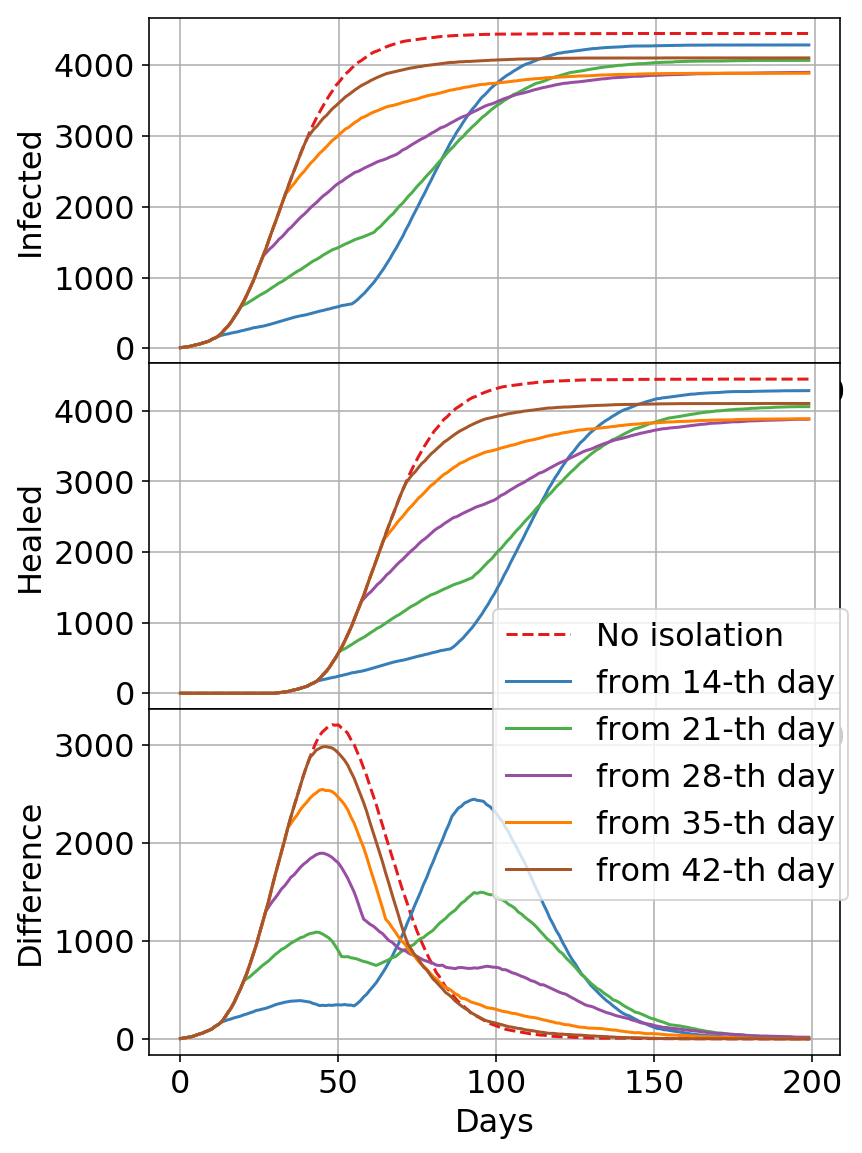

Experiment 3:  1


In [12]:
n=5000 #number of nodes
p=0.02 # probability of transfering the desease
Tmax=200
m=3

#Generate the social graph
G = RandTempGraph(n,m,Tmax)
infsetup=[0,5,7] #,5,7,10] #set up initial infected nodes

r=[1]
w=42 #period of isolation
t= [-1,14,21,28,35,42] #times to start isolation #must be smaller than Tmax!!
print("Experiment 3: ",isolationExper(G, infsetup,w,t,Tmax,r))


Final Sums of all ever infected for random seed  1  is  [4153, 4124, 4070, 4048, 3959, 3951, 3935, 3912, 3907, 3900, 3867, 3871, 3892]
max values of infected-healed:  [1767 1674 1497 1443 1326 1445 1560 1680 1801 1897 2014 2113 2213]


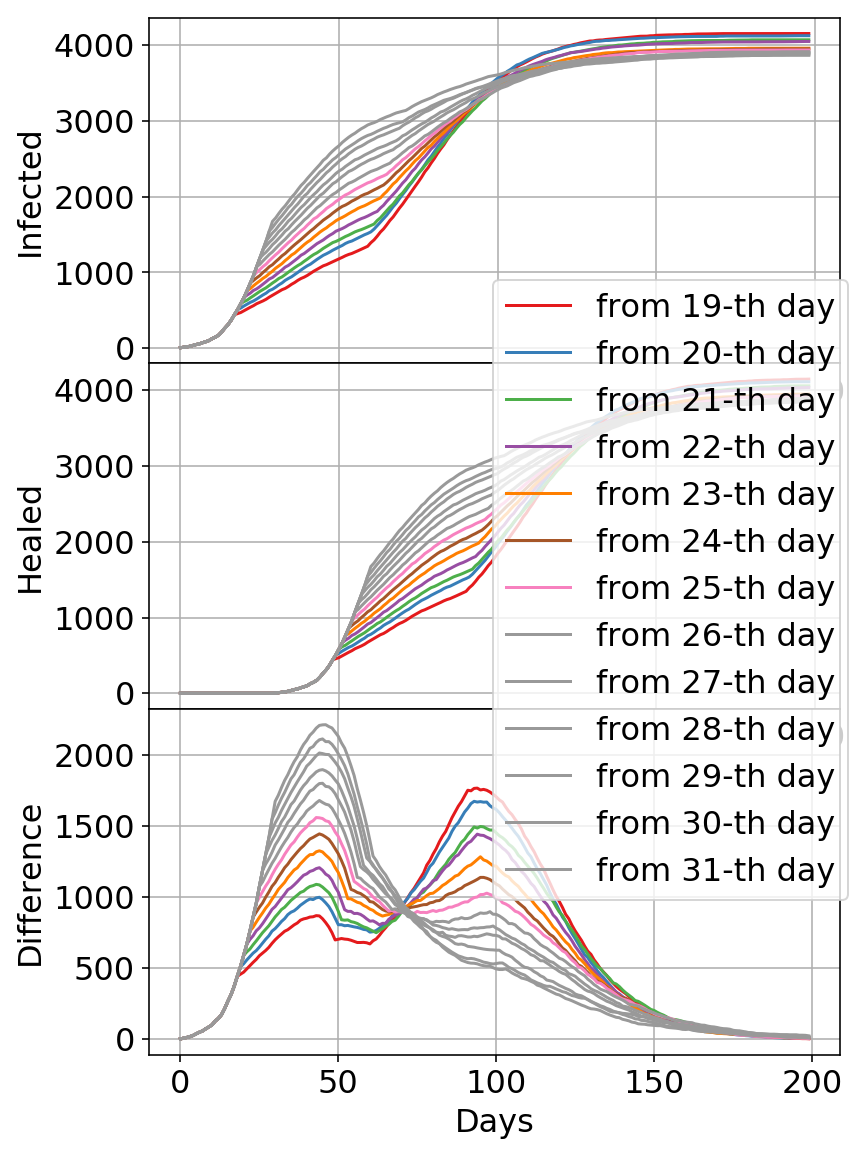

Experiment 1.1: Optimal minmax point 1


In [6]:
n=5000 #number of nodes
p=0.02 # probability of transfering the desease
Tmax=200
m=3

#Generate the social graph
G = RandTempGraph(n,m,Tmax)
infsetup=[0,5,7] #set up initial infected nodes

r=[1]
w=42 #period of isolation
t= [19,20,21,22,23,24,25,26,27,28,29,30,31] #times to start isolation #must be smaller than Tmax!!
print("Experiment 1.1: Optimal minmax point",isolationExper(G, infsetup,w,t,Tmax,r))


In [13]:
n=10000 #number of nodes
p=0.02 # probability of transfering the desease
Tmax=200
m=3

#Generate the social graph
G = RandTempGraph(n,m,Tmax)
Degs = G.degree
D=[x[1] for x in Degs]
#plt.hist(D)
#plt.show()
print("ave degs:", 1.0*sum(D)/len(D))

infsetup=[0,5,7] #set up initial infected nodes

r=[1]
w=42 #period of isolation
t= [-1,14,21,28,35,42] #times to start isolation #must be smaller than Tmax!!
print("Experiment 4: ",isolationExper(G, infsetup,w,t,Tmax,r))

ave degs: 5.9982
